In [1]:
import pandas as pd

# 加载播放记录（用户-歌曲-播放次数）
triplets = pd.read_csv('train_triplets.txt', sep='\t', header=None, names=['user_id', 'song_id', 'plays'])
print(triplets.head())

                                    user_id             song_id  plays
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995      1
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9      1
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B      2
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22      1
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFOVM12A58A7D494      1


In [2]:
import pandas as pd
import h5py

def load_metadata(filename):
    with h5py.File(filename, "r") as f:
        songs_dataset = f['metadata']['songs']
        
        # 提取原始字节数据
        song_ids_bytes = songs_dataset['song_id'][()]  # 字节数组
        titles_bytes = songs_dataset['title'][()]      # 字节数组
        
        # 安全解码为 UTF-8（处理非法字符）
        song_ids = [s.decode('utf-8', errors='ignore').strip() for s in song_ids_bytes]
        titles = [t.decode('utf-8', errors='ignore').strip() for t in titles_bytes]
        
        # 构建 DataFrame
        df = pd.DataFrame({
            'song_id': song_ids,
            'title': titles
        })
        
        # 移除空 song_id
        df = df[df['song_id'].str.len() > 0]
    return df

metadata = load_metadata('msd_summary_file.h5')

# 合并数据
merged_data = pd.merge(
    triplets,
    metadata,
    on='song_id',
    how='left'
)

# 验证结果
print("标题缺失比例:", merged_data['title'].isnull().mean())
print("示例数据:")
print(merged_data.head())

标题缺失比例: 0.0
示例数据:
                                    user_id             song_id  plays  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995      1   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9      1   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B      2   
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22      1   
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFOVM12A58A7D494      1   

                             title  
0                         The Cove  
1             Nothing from Nothing  
2                  Entre Dos Aguas  
3            Under Cold Blue Stars  
4  Riot Radio (Soundtrack Version)  


标题缺失比例: 0.0

🔍 Evaluating GMF...


Evaluating: 100%|██████████| 998/998 [00:38<00:00, 25.94it/s]



🔍 Evaluating MLP...


Evaluating: 100%|██████████| 998/998 [00:38<00:00, 26.02it/s]



🔍 Evaluating Fusion...


Evaluating: 100%|██████████| 998/998 [00:38<00:00, 25.69it/s]


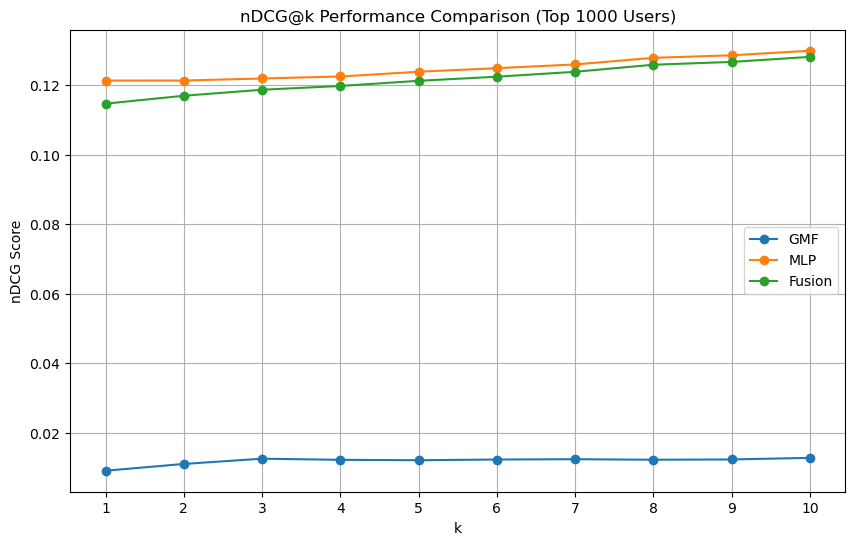


📊 评估结果汇总：
            1       2       3       4       5       6       7       8   \
GMF     0.0090  0.0110  0.0125  0.0122  0.0120  0.0122  0.0123  0.0122   
MLP     0.1213  0.1213  0.1219  0.1225  0.1239  0.1249  0.1260  0.1279   
Fusion  0.1147  0.1169  0.1187  0.1198  0.1212  0.1224  0.1238  0.1259   

            9       10  
GMF     0.0123  0.0127  
MLP     0.1286  0.1299  
Fusion  0.1267  0.1281  


In [10]:
import pandas as pd
import h5py
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm import tqdm

# =====================
# 1. 加载原始数据 & 元数据
# =====================
triplets = pd.read_csv(
    'train_triplets.txt', 
    sep='\t', 
    header=None, 
    names=['user_id', 'song_id', 'plays']
)

def load_metadata(filename):
    with h5py.File(filename, "r") as f:
        songs = f['metadata']['songs']
        song_ids = [s.decode('utf-8', errors='ignore').strip() 
                    for s in songs['song_id'][()]]
        titles   = [t.decode('utf-8', errors='ignore').strip() 
                    for t in songs['title'][()]]
        df = pd.DataFrame({'song_id': song_ids, 'title': titles})
        return df[df['song_id'].str.len() > 0]

metadata = load_metadata('msd_summary_file.h5')

# 合并
merged_data = pd.merge(triplets, metadata, on='song_id', how='left')
print("标题缺失比例:", merged_data['title'].isnull().mean())

# =====================
# 2. 字符串ID → 整数编码
# =====================
user_le = LabelEncoder()
song_le = LabelEncoder()
merged_data['user_id_encoded'] = user_le.fit_transform(merged_data['user_id'])
merged_data['song_id_encoded'] = song_le.fit_transform(merged_data['song_id'])

# =====================
# 3. 划分训练/测试 & 筛选前1000活跃用户
# =====================
all_indices = np.arange(len(merged_data))
train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=42, shuffle=True
)

# 统计播放量并选 top 1000
user_play_counts = merged_data.groupby('user_id_encoded')['plays'].sum()
top_users = user_play_counts.sort_values(ascending=False).head(1000).index.tolist()

# 测试集只保留活跃用户
test_df = merged_data.iloc[test_indices]
test_df = test_df[test_df['user_id_encoded'].isin(top_users)]

# 构建正样本 & 测试用户列表
user_positives = test_df.groupby('user_id_encoded')['song_id_encoded']\
                        .apply(list).to_dict()
test_users = list(user_positives.keys())
all_items  = merged_data['song_id_encoded'].unique()

# =====================
# 4. 加载已训练模型
# =====================
gmf_model    = load_model('best_gmf_model.keras')
mlp_model    = load_model('best_mlp_model.keras')
fusion_model = load_model('best_fusion_model.keras')

models = {
    "GMF":    gmf_model,
    "MLP":    mlp_model,
    "Fusion": fusion_model
}

# =====================
# 5. nDCG 计算工具
# =====================
def batch_predict(model, user_ids, item_ids):
    """批量预测，确保输入 int32"""
    u = np.array(user_ids, dtype=np.int32)
    v = np.array(item_ids, dtype=np.int32)
    return model.predict(
        {'user_input': u, 'item_input': v},
        batch_size=8192, verbose=0
    ).flatten()

def compute_ndcg(model, test_users, test_positives, item_pool, k_list):
    ndcg_results = {k: [] for k in k_list}
    for uid in tqdm(test_users, desc="Evaluating"):
        pos = test_positives.get(uid, [])
        if not pos:
            continue
        # 构造候选集：正样本 + 随机负样本
        cands = list(pos) + list(
            np.random.choice(
                item_pool,
                size=min(500, len(item_pool) - len(pos)),
                replace=False
            )
        )
        preds = batch_predict(model, [uid]*len(cands), cands)
        true_rel = np.isin(cands, pos).astype(int)
        for k in k_list:
            if len(pos) < k:
                continue
            ndcg_results[k].append(ndcg_score([true_rel], [preds], k=k))
    return {k: np.mean(v) for k, v in ndcg_results.items()}

# =====================
# 6. 执行评估 & 可视化
# =====================
k_values = [1,2,3,4,5,6,7,8,9,10]
results = {}

for name, m in models.items():
    print(f"\n🔍 Evaluating {name}...")
    results[name] = compute_ndcg(
        model=m,
        test_users=test_users,
        test_positives=user_positives,
        item_pool=all_items,
        k_list=k_values
    )

plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(k_values, [scores[k] for k in k_values],
             marker='o', label=name)
plt.title('nDCG@k Performance Comparison (Top 1000 Users)')
plt.xlabel('k')
plt.ylabel('nDCG Score')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

result_df = pd.DataFrame(results).T
print("\n📊 评估结果汇总：")
print(result_df.round(4))